# MSA 2025 Phase 2 - Part 2: Minimum Temperature Prediction from Weather Data

In [371]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## 1. Load and check the dataset

In [346]:
# Read the CSV file into a df
df = pd.read_csv('Summary of Weather.csv',dtype=str)   # Ensure all data is read as strings since some columns may contain mixed types

In [347]:
# Get first 10 rows from df
pd.set_option('display.max_columns', None)   # Set the display size
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
print(df.head(10))

     STA       Date Precip WindGustSpd      MaxTemp      MinTemp     MeanTemp Snowfall PoorWeather  YR MO  DA  PRCP   DR  SPD MAX MIN MEA SNF  SND   FT   FB  FTI  ITH  PGT TSHDSBRSGF  SD3  RHX  RHN  RVG  WTE
0  10001   1942-7-1  1.016         NaN  25.55555556  22.22222222  23.88888889        0         NaN  42  7   1  0.04  NaN  NaN  78  72  75   0  NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN
1  10001   1942-7-2      0         NaN  28.88888889  21.66666667  25.55555556        0         NaN  42  7   2     0  NaN  NaN  84  71  78   0  NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN
2  10001   1942-7-3   2.54         NaN  26.11111111  22.22222222  24.44444444        0         NaN  42  7   3   0.1  NaN  NaN  79  72  76   0  NaN  NaN  NaN  NaN  NaN  NaN        NaN  NaN  NaN  NaN  NaN  NaN
3  10001   1942-7-4   2.54         NaN  26.66666667  22.22222222  24.44444444        0         NaN  42  7   4   0.1  NaN  NaN  80  72  76   0  NaN  NaN  NaN  NaN  NaN  

There are 31 columns in this dataset. From the first ten lines, we can see that some columns contain non-numeric data, which causes the file to be incorrectly identified as numeric when read. This is an issue that we need to focus on in our subsequent processing.

## 2. Clean the dataset, drop variables

### 1. Data Cleaning

When reading CSV files, we temporarily set all columns as string types. For subsequent modeling and analysis, we now need to convert columns to numeric variables so that they can be used as training data. 

#### - [1] Date

In [348]:
# Drop the original 'Date' column
df.drop(columns=['Date'], inplace=True)


To ensure that all variables are numeric, delete the original 'Date' column, since the data already includes the month, day, and year columns.

#### - [2] Replace non-numeric characters

In [349]:
df_num = df.copy()  # Create a copy of the DataFrame for numerical operations

# Initialization: An empty list is used to store columns where data type conversion failed.
failed_conversion_columns = []

# Iterate through all columns and try to convert them to numeric values.
for col in df_num.columns:
    try:
        df_num[col] = pd.to_numeric(df_num[col], errors='raise')  # If conversion fails, an exception is raised.
    except:
        failed_conversion_columns.append(col)  # Record column where conversion failed

# Find unique non-numeric values for columns that failed to convert
non_numeric_values = {}
for col in failed_conversion_columns:
    is_not_numeric = pd.to_numeric(df[col], errors='coerce').isna()
    non_numeric_values[col] = df[col][is_not_numeric].dropna().unique() 

non_numeric_values

{'Precip': array(['T'], dtype=object),
 'Snowfall': array(['#VALUE!'], dtype=object),
 'PoorWeather': array(['1     1', '1 1', '1     1  1', '1  1', '1        1', '1   1 1',
        '1    1', '1     0', '11 1', '11    1', '1 1  1', '1 0  1', '1 0',
        '1   1 1  1', '1   1'], dtype=object),
 'PRCP': array(['T'], dtype=object),
 'SNF': array(['T'], dtype=object),
 'TSHDSBRSGF': array(['1     1', '1 1', '1     1  1', '1  1', '1        1', '1   1 1',
        '1    1', '1     0', '11 1', '11    1', '1 1  1', '1 0  1', '1 0',
        '1   1 1  1', '1   1'], dtype=object)}

Identify columns in the data set that cannot be successfully converted to numeric values, and extract all non-numeric unique values from these columns for subsequent targeted cleaning.

##### 1) 'PoorWeather' & 'TSHDSBRSGF'

When viewing the dataset, I noticed that the columns 'PoorWeather' and 'TSHDSBRSGF' are very similar, and I suspect that they are duplicate columns.

In [350]:
df_num['PoorWeather'].equals(df_num['TSHDSBRSGF'])

True

After checking, they were found to be duplicate columns, so one of the columns, ‘PoorWeather’, was deleted.


In [351]:
df_num = df_num.drop(columns='PoorWeather')  # Drop the 'PoorWeather' column

After that, we tried to convert the “TSHDSBRSGF” column into a numeric type column. After querying the specific meaning of this column, we found that it was usually a fixed-order multi-digit code, with each digit representing a specific weather event and corresponding to the alphabet in the column name.

In [352]:
# Replace spaces and standardize length for 'TSHDSBRSGF'
df_num['TSHDSBRSGF'] = df['TSHDSBRSGF'].fillna('').str.replace(' ', '0')
df_num['TSHDSBRSGF'] = df_num['TSHDSBRSGF'].str.pad(width=10, side='right', fillchar='0')

# Split 'TSHDSBRSGF' into individual weather flags
weather_flags = df_num['TSHDSBRSGF'].apply(lambda x: pd.Series(list(x)))
weather_flags.columns = [
    'Thunderstorm', 'Snow', 'Hail', 'Dust', 'Smoke',
    'BlowingSnow', 'Rain', 'Showers', 'Glaze', 'Fog'
]

# Convert weather flags to numeric values
weather_flags = weather_flags.apply(pd.to_numeric, errors='coerce')

In [353]:
# Drop the original 'TSHDSBRSGF' column and join the new weather flags DataFrame
df_num = df_num.drop(columns=['TSHDSBRSGF']).join(weather_flags)

df_num.head(10)  # Display the first 5 rows of the modified DataFrame

,STA,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,PRCP,DR,SPD,MAX,MIN,MEA,SNF,SND,FT,FB,FTI,ITH,PGT,SD3,RHX,RHN,RVG,WTE,Thunderstorm,Snow,Hail,Dust,Smoke,BlowingSnow,Rain,Showers,Glaze,Fog
0,10001,1.016,NaN,25.555556,22.222222,23.888889,0,42,7,1,0.04,NaN,NaN,78.0,72.0,75.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
1,10001,0,NaN,28.888889,21.666667,25.555556,0,42,7,2,0,NaN,NaN,84.0,71.0,78.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
2,10001,2.54,NaN,26.111111,22.222222,24.444444,0,42,7,3,0.1,NaN,NaN,79.0,72.0,76.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
3,10001,2.54,NaN,26.666667,22.222222,24.444444,0,42,7,4,0.1,NaN,NaN,80.0,72.0,76.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
4,10001,0,NaN,26.666667,21.666667,24.444444,0,42,7,5,0,NaN,NaN,80.0,71.0,76.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
5,10001,0,NaN,26.666667,21.666667,24.444444,0,42,7,6,0,NaN,NaN,80.0,71.0,76.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
6,10001,T,NaN,28.333333,22.777778,25.555556,0,42,7,7,T,NaN,NaN,83.0,73.0,78.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
7,10001,3.556,NaN,26.666667,22.222222,24.444444,0,42,7,8,0.14,NaN,NaN,80.0,72.0,76.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
8,10001,T,NaN,27.222222,22.777778,25.000000,0,42,7,9,T,NaN,NaN,81.0,73.0,77.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
9,10001,3.556,NaN,25.555556,21.666667,23.333333,0,42,7,10,0.14,NaN,NaN,78.0,71.0,74.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0


First, we replaced spaces with 0 and filled it with strings of length 10 to ensure that each digit represented a specific weather event. Next, we split the column into 10 separate columns and named them after actual weather phenomena. Finally, we converted these new columns to numeric values (0 or 1).

##### 2) 'Precip' & 'PRCP' & 'SNF'

The non-numeric value ‘T’ appears in all three columns. Through research, we found that ‘T’ usually stands for ‘trace amount’, which means that the actual value is extremely small but not zero, and is often used in variables such as precipitation or snowfall. To ensure that the data can be used for modeling analysis, we uniformly replaced ‘T’ with 0.001.

In [354]:
# Replace 'T' with 0.001 in specific columns and convert to numeric
for col in ['Precip', 'PRCP', 'SNF']:
    if col in df_num.columns:
        df_num[col] = df_num[col].replace("T", 0.001)
        df_num[col] = pd.to_numeric(df_num[col], errors='coerce')

df_num.head(10)  # Display the first 5 rows of the modified DataFrame

,STA,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,PRCP,DR,SPD,MAX,MIN,MEA,SNF,SND,FT,FB,FTI,ITH,PGT,SD3,RHX,RHN,RVG,WTE,Thunderstorm,Snow,Hail,Dust,Smoke,BlowingSnow,Rain,Showers,Glaze,Fog
0,10001,1.016,NaN,25.555556,22.222222,23.888889,0,42,7,1,0.040,NaN,NaN,78.0,72.0,75.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
1,10001,0.000,NaN,28.888889,21.666667,25.555556,0,42,7,2,0.000,NaN,NaN,84.0,71.0,78.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
2,10001,2.540,NaN,26.111111,22.222222,24.444444,0,42,7,3,0.100,NaN,NaN,79.0,72.0,76.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
3,10001,2.540,NaN,26.666667,22.222222,24.444444,0,42,7,4,0.100,NaN,NaN,80.0,72.0,76.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
4,10001,0.000,NaN,26.666667,21.666667,24.444444,0,42,7,5,0.000,NaN,NaN,80.0,71.0,76.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
5,10001,0.000,NaN,26.666667,21.666667,24.444444,0,42,7,6,0.000,NaN,NaN,80.0,71.0,76.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
6,10001,0.001,NaN,28.333333,22.777778,25.555556,0,42,7,7,0.001,NaN,NaN,83.0,73.0,78.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
7,10001,3.556,NaN,26.666667,22.222222,24.444444,0,42,7,8,0.140,NaN,NaN,80.0,72.0,76.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
8,10001,0.001,NaN,27.222222,22.777778,25.000000,0,42,7,9,0.001,NaN,NaN,81.0,73.0,77.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
9,10001,3.556,NaN,25.555556,21.666667,23.333333,0,42,7,10,0.140,NaN,NaN,78.0,71.0,74.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0


##### 3) 'Snowfall'


'#VALUE!' may be an invalid value. We replace it with a missing value NaN for subsequent processing (such as filling or deletion).

In [355]:
# Replace '#VALUE!' with NaN in 'Snowfall' column and convert to numeric
df_num['Snowfall'] = df_num['Snowfall'].replace('#VALUE!', pd.NA)
df_num['Snowfall'] = pd.to_numeric(df_num['Snowfall'], errors='coerce')

##### 4) Data types

In [356]:
df_num.dtypes

STA               int64
Precip          float64
WindGustSpd     float64
MaxTemp         float64
MinTemp         float64
MeanTemp        float64
Snowfall        float64
YR                int64
MO                int64
DA                int64
PRCP            float64
DR              float64
SPD             float64
MAX             float64
MIN             float64
MEA             float64
SNF             float64
SND             float64
FT              float64
FB              float64
FTI             float64
ITH             float64
PGT             float64
SD3             float64
RHX             float64
RHN             float64
RVG             float64
WTE             float64
Thunderstorm      int64
Snow              int64
Hail              int64
Dust              int64
Smoke             int64
BlowingSnow       int64
Rain              int64
Showers           int64
Glaze             int64
Fog               int64
dtype: object

### 2. Drop Varibales

#### [1] Duplicate columns

In the dataset, we found that several variables had similar names and similar meanings (e.g., MaxTemp and MAX, Snowfall and SNF). To avoid redundant features affecting model performance, we used a heat map to analyze the correlations between them, identified highly correlated columns, and decided to retain one representative variable and delete or ignore the remaining redundant columns.

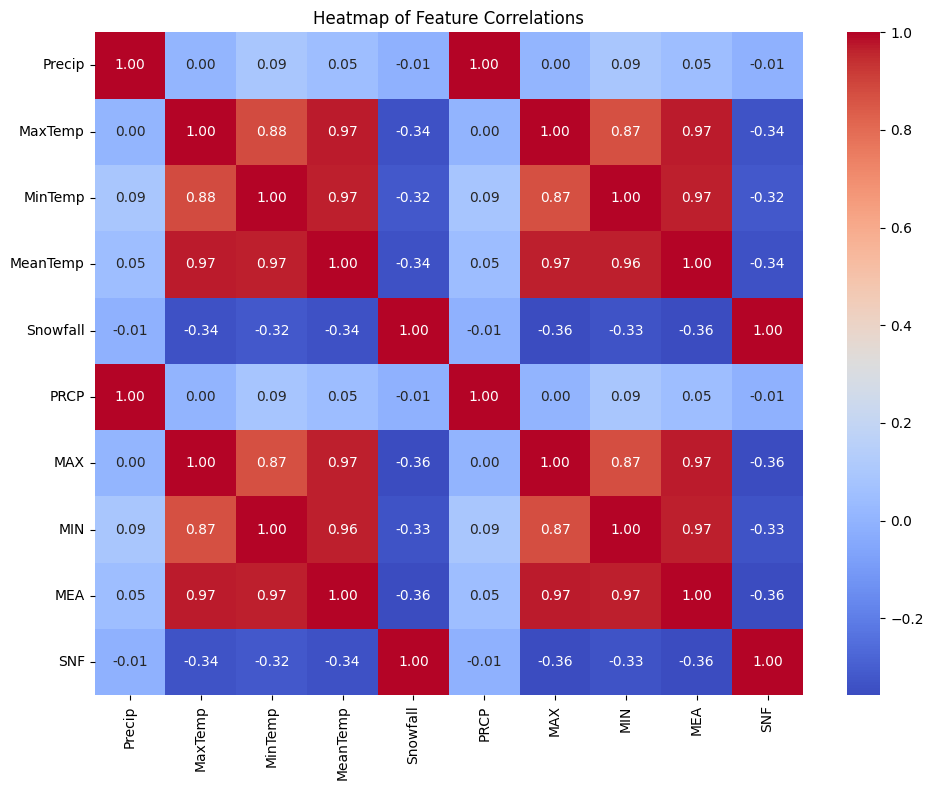

In [357]:
# Calculate the correlation matrix for the relevant columns
corr_matrix = df_num[['Precip',	'MaxTemp',	'MinTemp',	'MeanTemp',	'Snowfall',	'PRCP',	'MAX',	'MIN',	'MEA',	'SNF']].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap of Feature Correlations")
plt.tight_layout()
plt.show()


Some variables are highly linearly correlated. For example, the correlation coefficients between MaxTemp and MAX, MeanTemp and MEA, and MinTemp and MIN are all close to 0.97 or higher. In addition, PRCP and Precip are almost identical, as are SNF and Snowfall.

In [358]:
# Remove redundant columns based on high correlation
redundant_columns = ['PRCP', 'MAX', 'MIN', 'MEA', 'SNF']
df_num = df_num.drop(columns=redundant_columns)

#### [2] Missing values

In [359]:
# Calculate the ratio of missing values in each column
missing_ratio = df_num.isna().mean()
print(missing_ratio.sort_values(ascending=False).to_string())

FT              1.000000
WTE             1.000000
FB              1.000000
FTI             1.000000
ITH             1.000000
RVG             1.000000
RHN             1.000000
RHX             1.000000
SD3             1.000000
PGT             0.995590
WindGustSpd     0.995531
SPD             0.995531
DR              0.995523
SND             0.953268
Snowfall        0.010139
STA             0.000000
YR              0.000000
DA              0.000000
MeanTemp        0.000000
MaxTemp         0.000000
Precip          0.000000
MinTemp         0.000000
MO              0.000000
Thunderstorm    0.000000
Snow            0.000000
Hail            0.000000
Dust            0.000000
Smoke           0.000000
BlowingSnow     0.000000
Rain            0.000000
Showers         0.000000
Glaze           0.000000
Fog             0.000000


In [360]:
# Drop columns with more than 50% missing values
df_num = df_num.loc[:, df_num.isna().mean() < 0.5]
df_num.head(10)  # Display the first 5 rows of the modified DataFrame

,STA,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,Thunderstorm,Snow,Hail,Dust,Smoke,BlowingSnow,Rain,Showers,Glaze,Fog
0,10001,1.016,25.555556,22.222222,23.888889,0.0,42,7,1,0,0,0,0,0,0,0,0,0,0
1,10001,0.000,28.888889,21.666667,25.555556,0.0,42,7,2,0,0,0,0,0,0,0,0,0,0
2,10001,2.540,26.111111,22.222222,24.444444,0.0,42,7,3,0,0,0,0,0,0,0,0,0,0
3,10001,2.540,26.666667,22.222222,24.444444,0.0,42,7,4,0,0,0,0,0,0,0,0,0,0
4,10001,0.000,26.666667,21.666667,24.444444,0.0,42,7,5,0,0,0,0,0,0,0,0,0,0
5,10001,0.000,26.666667,21.666667,24.444444,0.0,42,7,6,0,0,0,0,0,0,0,0,0,0
6,10001,0.001,28.333333,22.777778,25.555556,0.0,42,7,7,0,0,0,0,0,0,0,0,0,0
7,10001,3.556,26.666667,22.222222,24.444444,0.0,42,7,8,0,0,0,0,0,0,0,0,0,0
8,10001,0.001,27.222222,22.777778,25.000000,0.0,42,7,9,0,0,0,0,0,0,0,0,0,0
9,10001,3.556,25.555556,21.666667,23.333333,0.0,42,7,10,0,0,0,0,0,0,0,0,0,0


In [361]:
# Fill missing values in numeric columns with the median of each column
df_num = df_num.fillna(df_num.median(numeric_only=True))

Some columns with high proportions of missing values were removed by calculating the proportion of missing values, and then the remaining missing values were filled in using the median.

#### [3] One-hot coding


After checking, STA stands for station ID, which is used to identify which observation station each record comes from. Basically, it's a categorical variable, so we use one-hot encoding to convert it into multiple binary feature columns.

In [362]:
# Convert 'STA' column to categorical and one-hot encode it
df_num = pd.get_dummies(df_num, columns=['STA'])
df_num.head(10) 

,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,Thunderstorm,Snow,Hail,Dust,Smoke,BlowingSnow,Rain,Showers,Glaze,Fog,STA_10001,STA_10002,STA_10101,STA_10102,STA_10502,STA_10505,STA_10701,STA_10703,STA_10704,STA_10705,STA_10718,STA_10802,STA_10803,STA_10804,STA_10806,STA_10807,STA_11101,STA_11103,STA_11501,STA_11601,STA_11604,STA_11606,STA_11610,STA_11615,STA_11701,STA_11704,STA_11801,STA_11901,STA_11902,STA_12001,STA_12101,STA_12701,STA_12702,STA_12706,STA_12801,STA_13002,STA_13005,STA_13007,STA_13013,STA_13201,STA_13601,STA_15027,STA_16101,STA_16201,STA_16202,STA_16405,STA_16407,STA_16504,STA_20501,STA_20602,STA_21501,STA_22502,STA_22504,STA_22507,STA_22508,STA_22509,STA_30001,STA_31001,STA_31101,STA_31302,STA_31401,STA_31501,STA_31701,STA_32301,STA_32501,STA_32503,STA_32504,STA_32601,STA_32602,STA_32603,STA_32701,STA_32702,STA_32801,STA_32803,STA_32805,STA_32812,STA_32815,STA_32904,STA_32906,STA_32907,STA_33003,STA_33013,STA_33014,STA_33019,STA_33023,STA_33031,STA_33044,STA_33109,STA_33111,STA_33117,STA_33121,STA_33123,STA_33205,STA_33206,STA_33303,STA_33305,STA_33307,STA_33401,STA_33405,STA_33406,STA_33501,STA_34002,STA_34003,STA_34005,STA_34012,STA_34013,STA_34017,STA_34018,STA_34022,STA_34101,STA_34104,STA_34105,STA_34109,STA_34111,STA_34113,STA_34123,STA_34139,STA_34147,STA_34150,STA_40601,STA_41204,STA_41207,STA_42204,STA_42206,STA_42401,STA_43201,STA_43302,STA_43305,STA_43307,STA_44401,STA_50301,STA_50302,STA_50303,STA_50304,STA_50401,STA_50403,STA_50801,STA_50802,STA_60701,STA_61501,STA_61502,STA_62701,STA_80411,STA_80412,STA_80425,STA_80504,STA_80509,STA_80510,STA_81404,STA_81601,STA_81702,STA_82402,STA_82403,STA_82404,STA_82405,STA_82501,STA_82502,STA_82503,STA_82506
0,1.016,25.555556,22.222222,23.888889,0.0,42,7,1,0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.000,28.888889,21.666667,25.555556,0.0,42,7,2,0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2.540,26.111111,22.222222,24.444444,0.0,42,7,3,0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

## 3. Select the feature(s) for the model, and explain the reason


Use Lasso regression for feature selection. We will use MinTemp as the target variable and use LassoCV to extract the coefficients of all features, taking their absolute values as feature importance indicators.

In [ ]:
# Lasso regression for feature selection

# Target lable and all features
X = df_num.drop(columns=['MinTemp'])
y = df_num['MinTemp']

# Fit lasso model
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X, y)

# Get the importance of features from the lasso model
lasso_importance = pd.Series(np.abs(lasso.coef_), index=X.columns)
selected_features = lasso_importance[lasso_importance > 0].sort_values(ascending=False).to_frame(name="Importance")
selected_features

,Importance
MeanTemp,1.847113
MaxTemp,0.863170
Precip,0.003964
MO,0.003587
Snowfall,0.000532


In [ ]:
# Select the features with non-zero importance (coefficients)
feature_names = selected_features.index.tolist()
df_cleaned = df_num[['MinTemp'] + feature_names]
df_cleaned.head(5)

,MinTemp,MeanTemp,MaxTemp,Precip,MO,Snowfall
0,22.222222,23.888889,25.555556,1.016,7,0.0
1,21.666667,25.555556,28.888889,0.000,7,0.0
2,22.222222,24.444444,26.111111,2.540,7,0.0
3,22.222222,24.444444,26.666667,2.540,7,0.0
4,21.666667,24.444444,26.666667,0.000,7,0.0


 Finally, we will select those features with non-zero coefficients as variables with significant predictive power for MinTemp.

## 4. Split the dataset (80% for training, 20% for testing)

In [369]:
# Feature and target variable
X = df_cleaned.drop(columns=['MinTemp'])
y = df_cleaned['MinTemp']

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 5. Choose the algorithm, train and test the model

### 1. Linear Regression

In [372]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

## 6. Evaluate and Visualize model Performance

### 1. Linear Regression

,Model,RMSE,R²
0,Linear Regression,0.851029,0.989472


## 7. What is the R² value and RMSE of the model? How these values indicate the model performance?

In [375]:
# Calculate RMSE and R² for the linear regression model
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_lr = r2_score(y_test, y_pred)

# Summary DataFrame for the linear regression model
summary_lr = pd.DataFrame({
    "Model": ["Linear Regression"],
    "RMSE": [rmse_lr],
    "R²": [r2_lr]
})

# Display the summary DataFrame
print(summary_lr)

               Model      RMSE        R²
0  Linear Regression  0.851029  0.989472


## 8. Discuss the model performance based on the plot

In [365]:
# write your answer here